In [1]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')


import time
import os
import glob
import torch
import cv2
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import wandb
from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f,LogLevel


from torch_openpose.body import Body
from torch_openpose import util



In [2]:
# FUNCTIONS
def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt", 
        reinit = True,
        name = name,
        config={
            "epochs": 1,
            "regularizer": 0,
            "learning_rate": 0.2,
            "paf_scale": 2.0,
            "batch_size": 2,
            "noise_width": 1024,
            "noise_height": 1024,
            "spp": 8,
            "optimizer": 'ADAM'
        }
    )
    
    return run 

def get_scenes_filenames(directory, include_filter=[], lim=10000000):
    scenes = []
    
    for file in tqdm(glob.glob(f"{directory}/*.xml")):
        if len(include_filter) == 0:
            scenes.append(file)
        else:
            for mesh_name in include_filter:
                if mesh_name in file:
                    scenes.append(file)
                    break
        
        if len(scenes) > lim:
            break
    # shuffel scenes due to naming 
    random.seed(42)
    random.shuffle(scenes)
    
    return scenes

def get_candidate_from_tensor(rendering_torch, body_estimation):
    PERMUTE_BGR = [2, 1, 0]
     # make torch RGB to BGR and permute and stack
    rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
    # this should be not need, but the rendering has values above 1
    max_val = torch.max(rendering_torch_BGR)
    rendering_torch_BGR = rendering_torch_BGR / max_val
    
    rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])
    
    # Render a reference image (no derivatives used yet)
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  rendering_torch_BGR.detach().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset

def get_image_and_score(scene_path, params_torch, body_estimation, diff_parameter, device, spp=8):
    thread = Thread.thread()
    thread.file_resolver().append(test_dir)
    logger = thread.logger()
    logger.set_log_level(LogLevel.Warn)
    
    # load scene
    scene = load_file(scene_path)
    params = traverse(scene)
    rendering_torch = render_torch(scene, spp=spp)
    rendering_torch_tm = linear_to_srgb_tensor(rendering_torch, device)
    with torch.no_grad():
        rendering_torch_tm.clamp_(0, 1)
    canvas_orig, candidate_orig, subset_orig = get_candidate_from_tensor(rendering_torch_tm, body_estimation)
   
    
    # update the params with the new noise value
    params[diff_parameter] = params_torch[diff_parameter].detach().cpu().numpy()
    params.update()
    
    rendering_torch = render_torch(scene, params=params, unbiased=False, malloc_trim=True, spp=spp, **params_torch)
    rendering_torch_tm = linear_to_srgb_tensor(rendering_torch, device)
    with torch.no_grad():
        rendering_torch_tm.clamp_(0, 1)
    canvas_noise, candidate_noise, subset_noise = get_candidate_from_tensor(rendering_torch_tm, body_estimation)
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    return canvas_orig[:, :, [2, 1, 0]], canvas_noise[:, :, [2, 1, 0]], metric, rendering_torch


def pose_loss_single_human(newHuman, oldHuman):
    if len(oldHuman) == 0 or len(newHuman) == 0:
        return 0
    new_detected = 0
    old_detected = 0
    for part in range(18):
        if newHuman[0][part] != -1:
            new_detected += 1
        if oldHuman[0][part] != -1:
            old_detected += 1
    return new_detected / old_detected

def getPolyVal(x, c):
    return c[5]  * x**5 + c[4]  * x**4  + c[3]  * x**3  + c[2]  * x**2  + c[1]  * x + c[0] 

def linear_to_srgb_tensor(x: torch.tensor, device):
    r = 12.92;
    zeros = torch.zeros(x.shape, device=device)
    
    small_mask = torch.where(x <= 0.0031308, x, zeros)
    small_mask *= r
    
    large_mask = torch.where(x > 0.0031308, x, zeros)
    
    
    y = torch.sqrt(large_mask)
    coeffs_p = torch.tensor([-0.0016829072605308378, 0.03453868659826638, 0.7642611304733891, 
         2.0041169284241644, 0.7551545191665577, -0.016202083165206348], device=device
    )
    p = getPolyVal(y, coeffs_p)

    coeffs_q = torch.tensor(
        [4.178892964897981e-7, -0.00004375359692957097, 0.03467195408529984, 
         0.6085338522168684, 1.8970238036421054, 1.], device=device
    )
    q = getPolyVal(y, coeffs_q)

    r = p / q
    result = (large_mask * r) + small_mask 

    return result

In [3]:
#CONSTS
STRIDE = 8
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
DATA_SET_NAME = 'tshirt_point_light'
snapshot_name = f'../snapshots/mts_tshirt__{DATA_SET_NAME}.npy'
train_dir = f'../data/{DATA_SET_NAME}/train'
test_dir = f'../data/{DATA_SET_NAME}/test'

include_filter = []

train_scenes = get_scenes_filenames(train_dir)
test_scenes = get_scenes_filenames(test_dir)
print(len(train_scenes))
print(len(test_scenes))


100%|██████████| 200/200 [00:00<00:00, 122838.01it/s]

1800
200


In [4]:
body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)
# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

thread = Thread.thread()
thread.file_resolver().append('master_data')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)

scene = load_file('master_data/master_RD_test_point_light.xml')

# Find differentiable scene parameters
params = traverse(scene)
diff_parameter = 'simulated.bsdf.reflectance.data'
run = wandb_init(f'tshirt_TM_{DATA_SET_NAME}')
noise_resolution  = np.array([run.config.noise_width, run.config.noise_height])

steps = len(train_scenes) // run.config.batch_size


cuda:0


In [ ]:
# Which parameters should be exposed to the PyTorch optimizer?
params.keep([diff_parameter])
params.update()
params_torch = params.torch() # main pytorch params

# Construct a PyTorch Adam optimizer that will adjust 'params_torch'
opt = None
if run.config.optimizer == "SGD":
    opt = torch.optim.SGD(params_torch.values(), lr=run.config.learning_rate)
else:
    opt = torch.optim.Adam(params_torch.values(), lr=run.config.learning_rate)

objective = torch.nn.MSELoss()
objective_pixels = torch.nn.L1Loss()

REGULARIZATION = torch.tensor(run.config.regularizer, device=device)
PAF_SCALE = torch.tensor(run.config.paf_scale, device=device)

# target
zero_heatmap = torch.zeros((run.config.batch_size, 19, 46, 54), device=device)
zero_paf = torch.zeros((run.config.batch_size, 38, 46, 54), device=device)
zeros = torch.zeros(params_torch[diff_parameter].shape, device=device)
ones = torch.ones(params_torch[diff_parameter].shape, device=device)

print("Constants set")
myThread = Thread.thread()
myThread.file_resolver().append(train_dir)
logger = myThread.logger()
logger.set_log_level(LogLevel.Warn)

global_step = 0
for epoch in range(run.config.epochs):
    print(f"run {epoch + 1}/{run.config.epochs}")
    for step in tqdm(range(steps)):
        if step % 50 ==  0 and step > 0:
            universal_noise_image = params_torch[diff_parameter].detach().cpu().numpy()
            universal_noise_image  = universal_noise_image.reshape(noise_resolution[1], noise_resolution[0], -1)    
            np.save(snapshot_name, universal_noise_image)
        opt.zero_grad()
        body_estimation.model.zero_grad() # probably not needed

        # list of all rendering from this batch
        rendering_batch = []

        for i in range(step * run.config.batch_size, (step * run.config.batch_size) + run.config.batch_size):
            scene = load_file(train_scenes[i])
            params = traverse(scene)
            params.keep([diff_parameter])

            # update the diffparamter
            params[diff_parameter] = params_torch[diff_parameter].detach().cpu().numpy()

            params.update()
            # render image
            # maybe add malloc_trim=True if memory issues
            cur_rednering_torch = render_torch(scene, params=params, unbiased=False, malloc_trim=True, spp=run.config.spp, **params_torch)
            cur_rednering_torch_tm = linear_to_srgb_tensor(cur_rednering_torch, device)
            
            with torch.no_grad():
                cur_rednering_torch_tm.clamp_(0, 1)

            # transform from rgb to bgr
            PERMUTE_BGR = [2, 1, 0]
            rendering_torch_BGR = cur_rednering_torch[:, :, PERMUTE_BGR]
            rendering_batch.append(rendering_torch_BGR.permute((2, 0, 1))  - 0.5)

        # permute channels to pytorch order and stack
        rendering_torch_input = torch.stack(rendering_batch)

        # compute the avg heatmap and paf map
        paf, heatmap = body_estimation.model(rendering_torch_input)

        ob_val_heat = objective(heatmap, zero_heatmap)
        ob_val_paf = objective(paf, zero_paf)
        
        y = params_torch[diff_parameter]
        
        negative_reg = torch.where(y < 0, y, zeros)
        positive_reg = torch.where(y > 1, y, zeros)

        ob_negative_reg = objective_pixels(negative_reg, zeros)
        ob_positive_reg = objective_pixels(positive_reg, zeros)
    
        y = y.view(noise_resolution[1], noise_resolution[0], 3).permute((2, 0, 1))        
        ob_tv = (torch.sum(torch.abs(y[:, :, :-1] - y[:, :, 1:])) + torch.sum(torch.abs(y[:, :-1, :] - y[:, 1:, :])))
        
        ob_val = (
            ob_val_heat  
            + PAF_SCALE * ob_val_paf 
            + ob_negative_reg 
            + ob_positive_reg
            + REGULARIZATION * ob_tv
        )

        # calc gradient
        ob_val.backward()

        # take a step in gradient direction
        opt.step()
        
        with torch.no_grad():
            params_torch[diff_parameter].clamp_(0, 1)

        # log the loss
        wandb.log({'loss': ob_val.item()}, step=global_step)
        global_step += 1
        

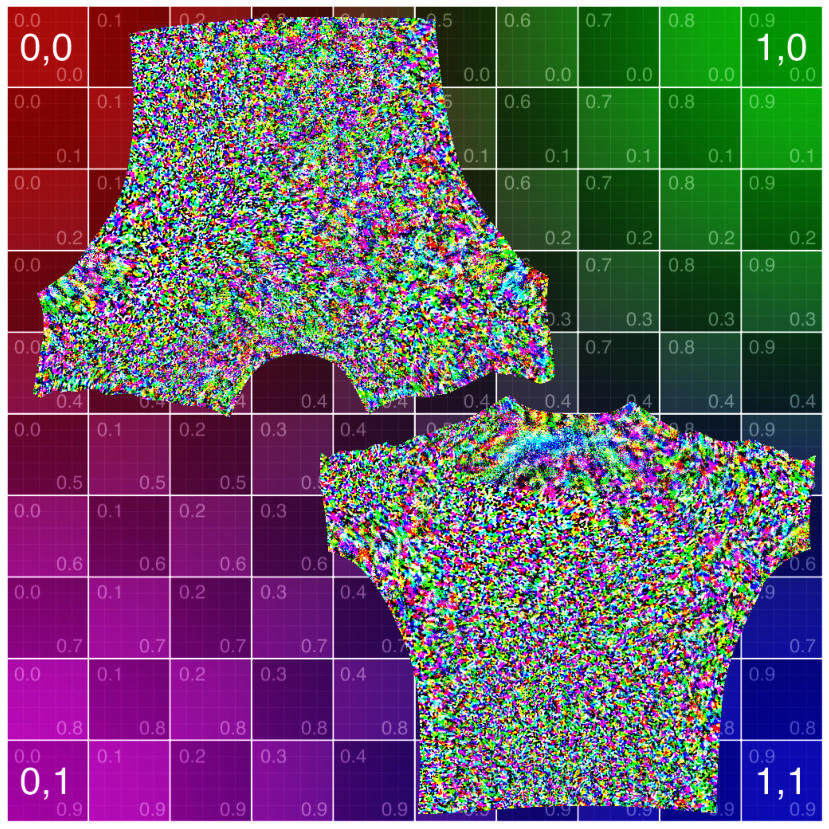

In [5]:
universal_noise_image = np.load(snapshot_name)

params.keep([diff_parameter])
params[diff_parameter] = universal_noise_image.flatten()
params.update()
params_torch = params.torch() # main pytorch params


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(universal_noise_image)
ax.axis('off')
np.save(snapshot_name, universal_noise_image)
#wandb.log({'universal_noise': fig})

In [6]:
canvas_orig_list = []
canvas_noise_list = []
metric_list = []
i = 0
for test_scene in tqdm(test_scenes):
    canvas_orig, canvas_noise, metric, _ = get_image_and_score(test_scene, params_torch, body_estimation, diff_parameter, device)
    canvas_orig_list.append(canvas_orig)
    canvas_noise_list.append(canvas_noise)
    metric_list.append(metric)
    i += 1

100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


In [7]:
print(f"Avg metric: {np.mean(metric_list)}")
wandb.log({'avgMetric': np.mean(metric_list)})

Avg metric: 0.8034775322716499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

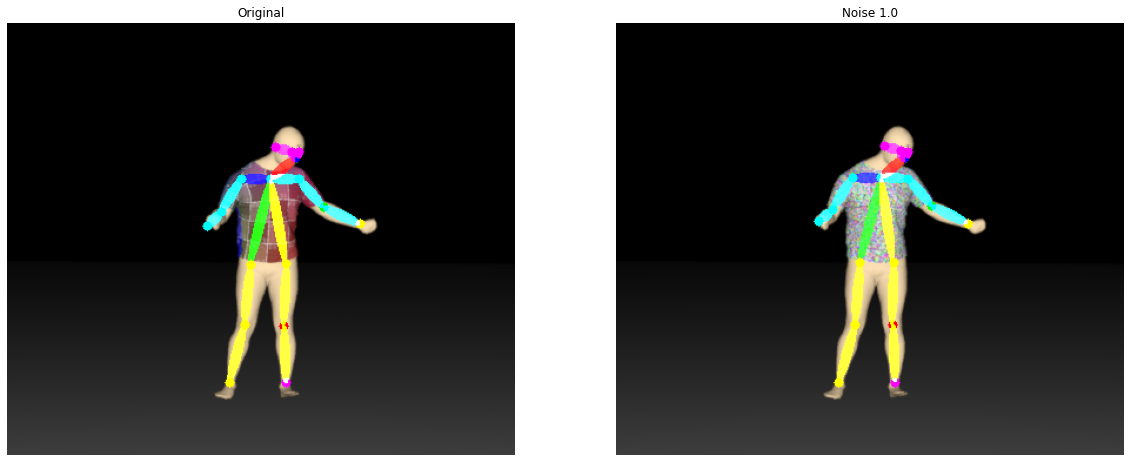

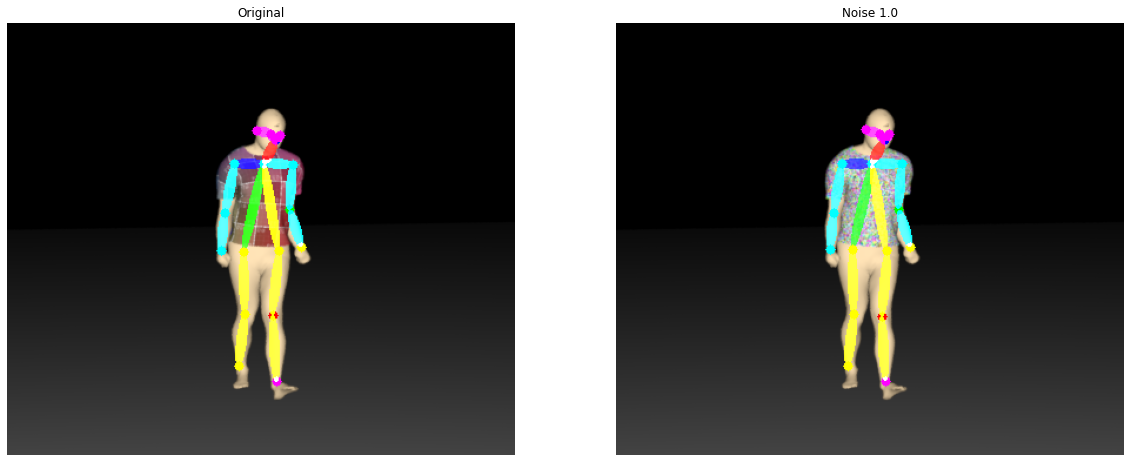

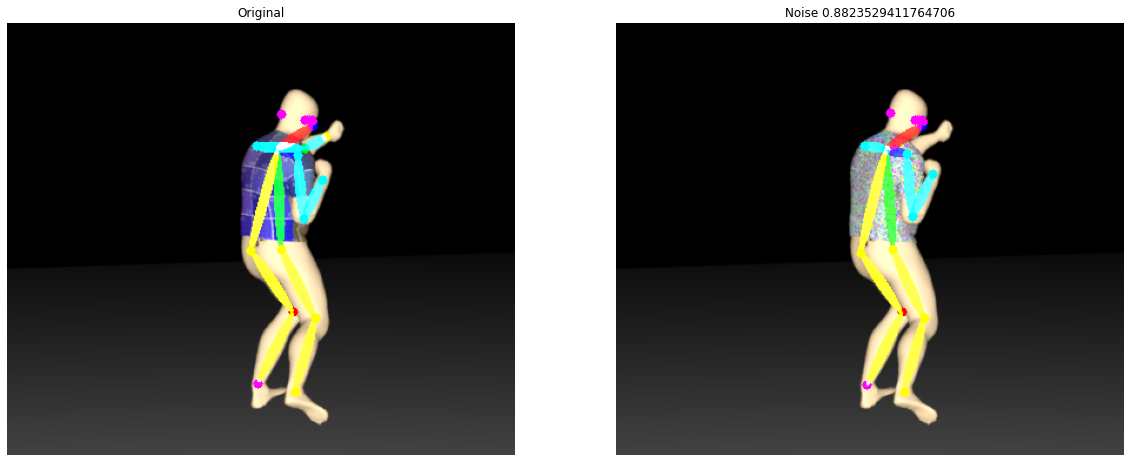

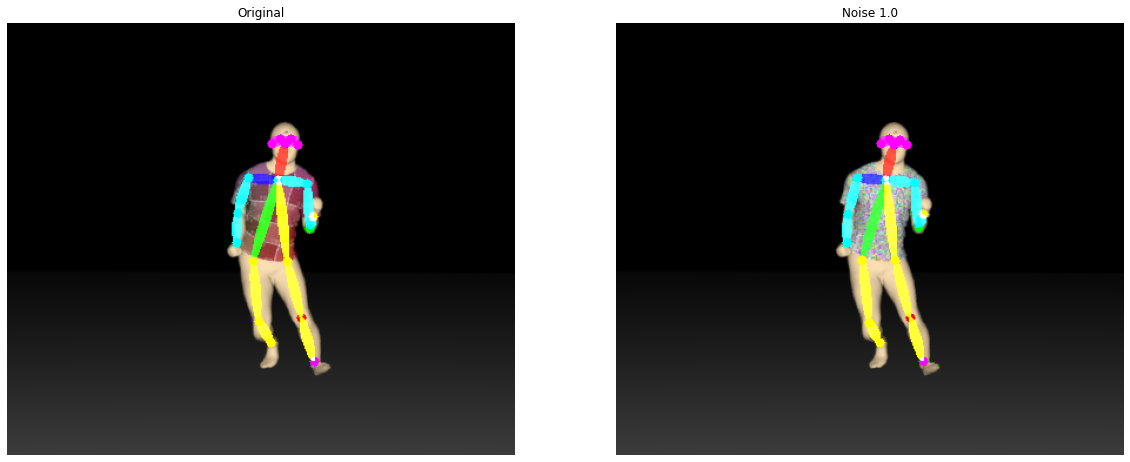

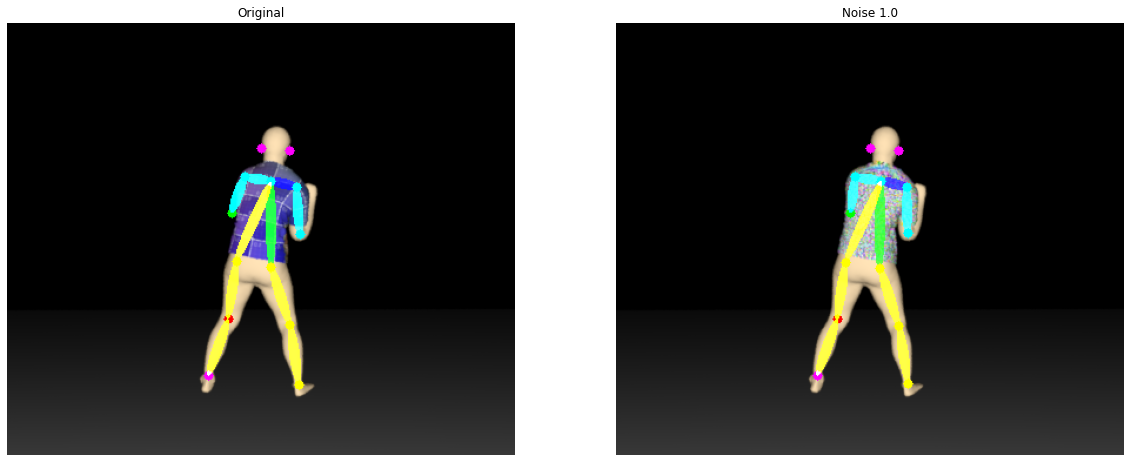

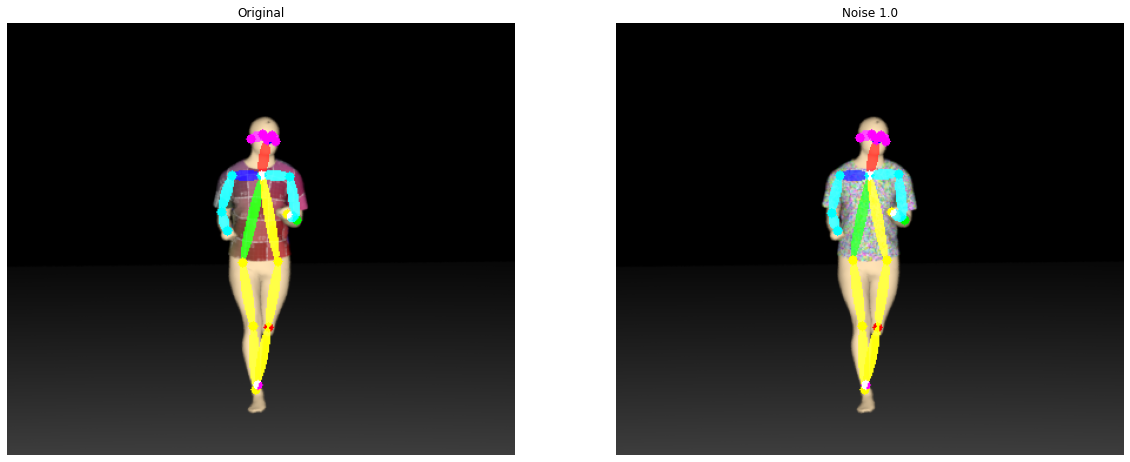

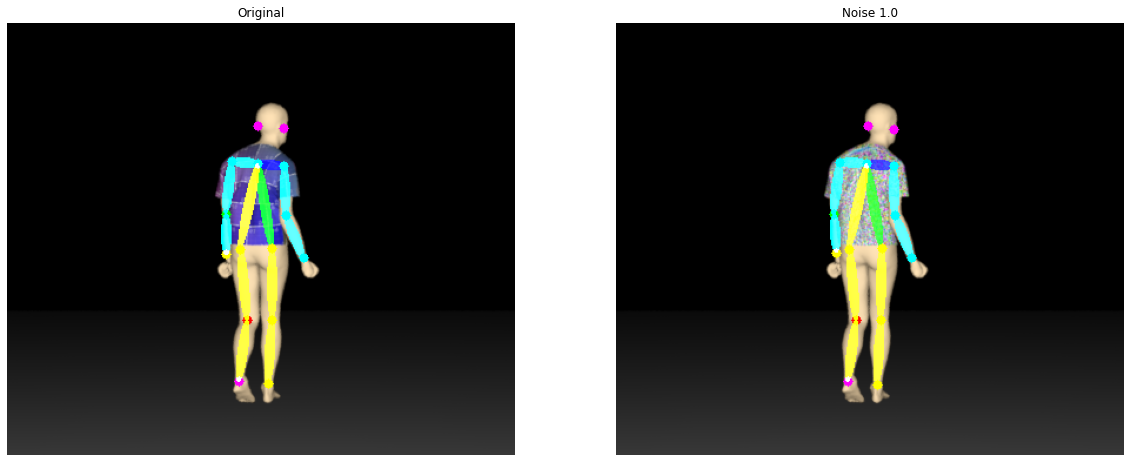

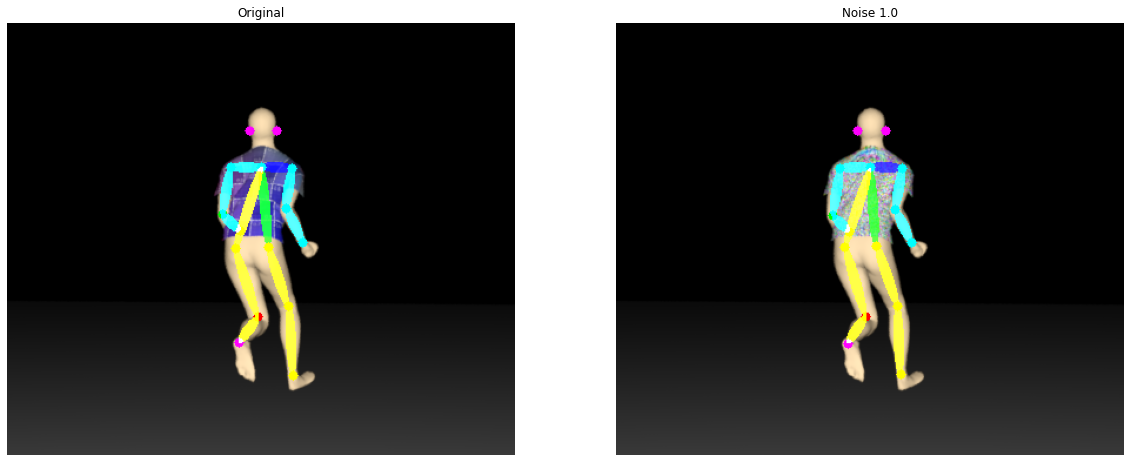

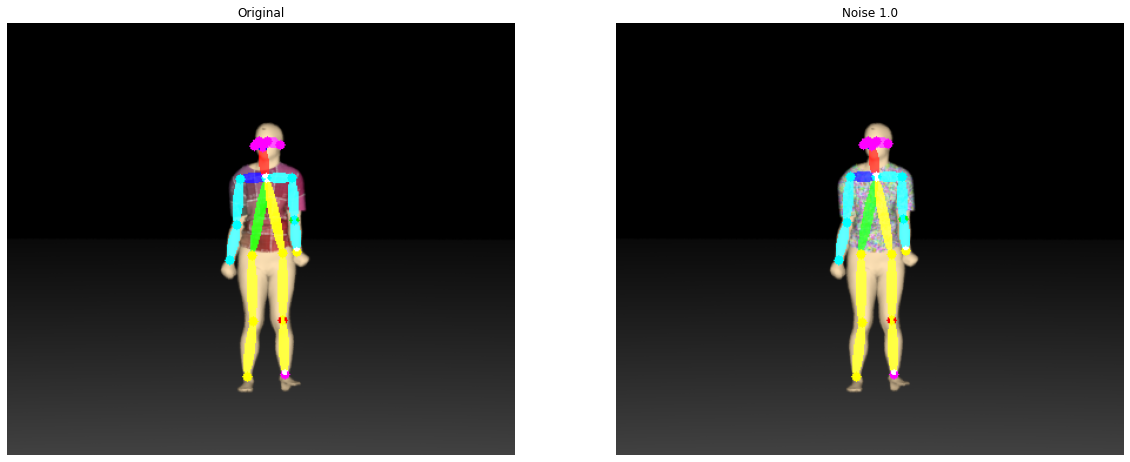

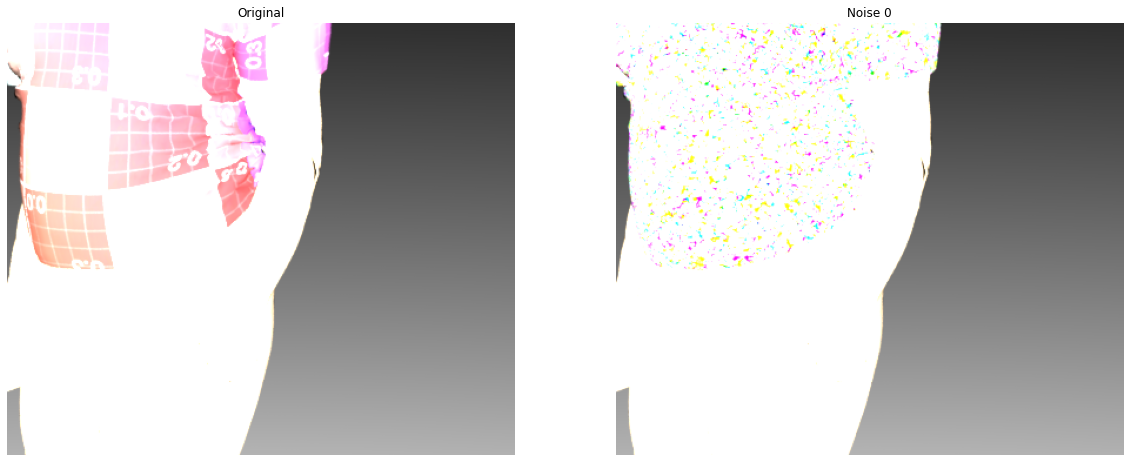

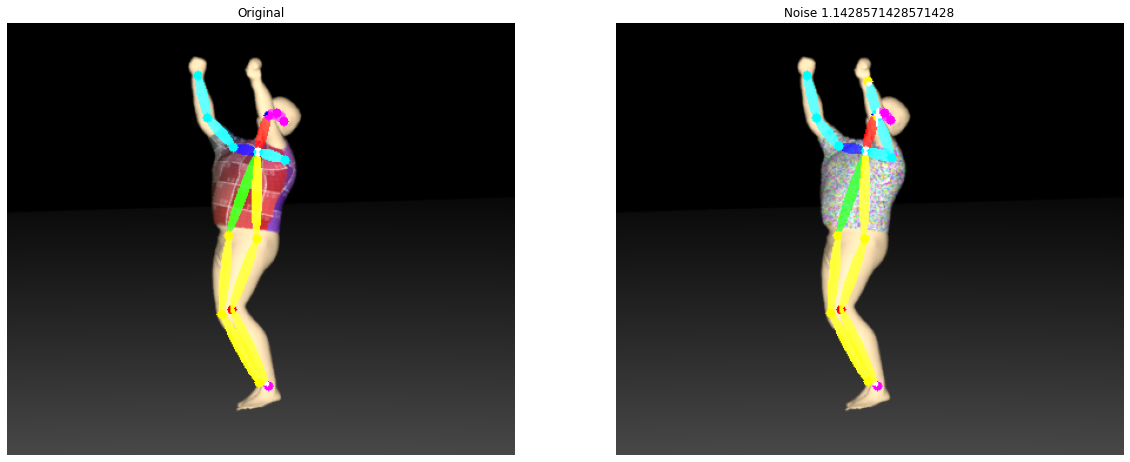

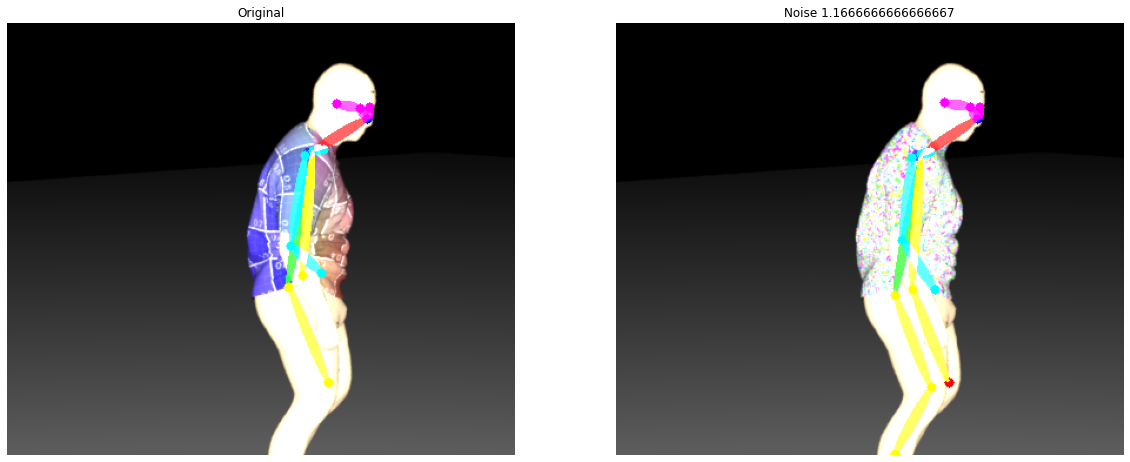

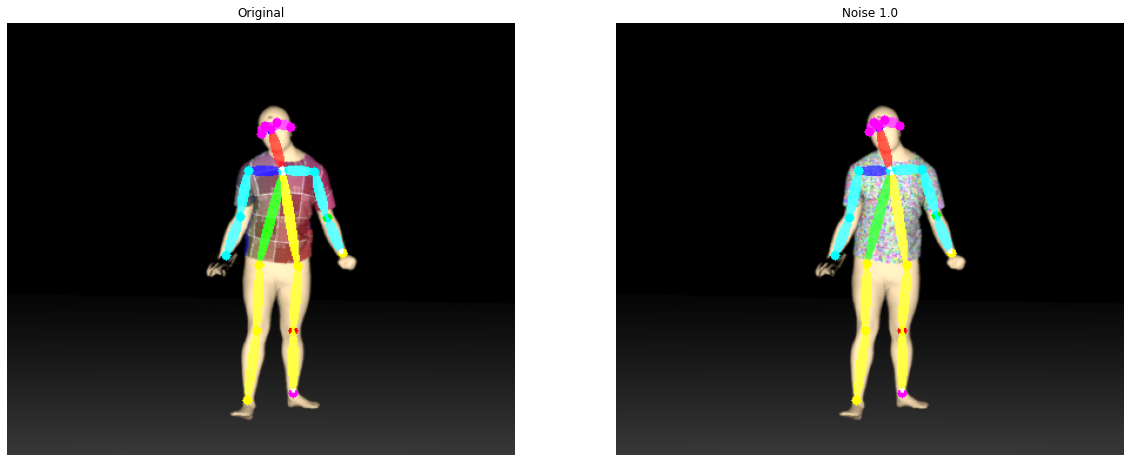

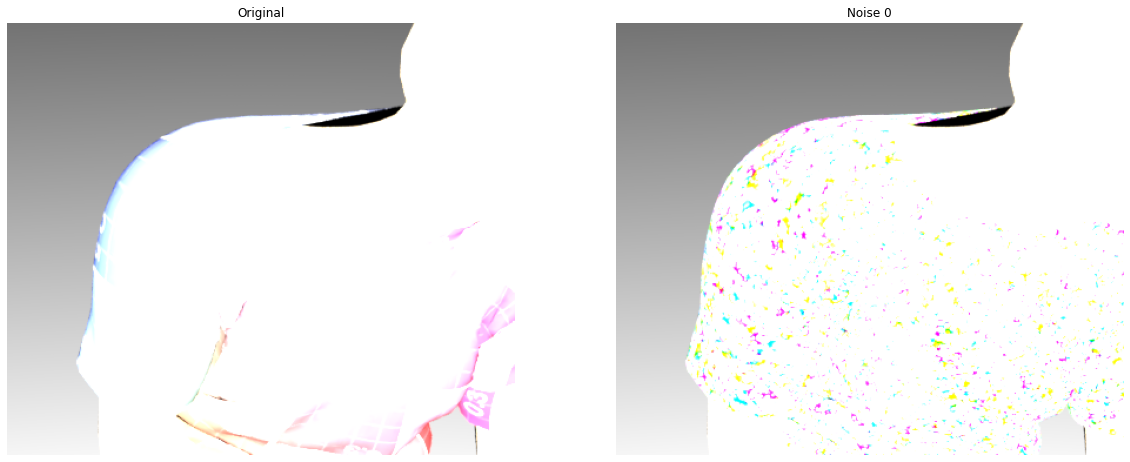

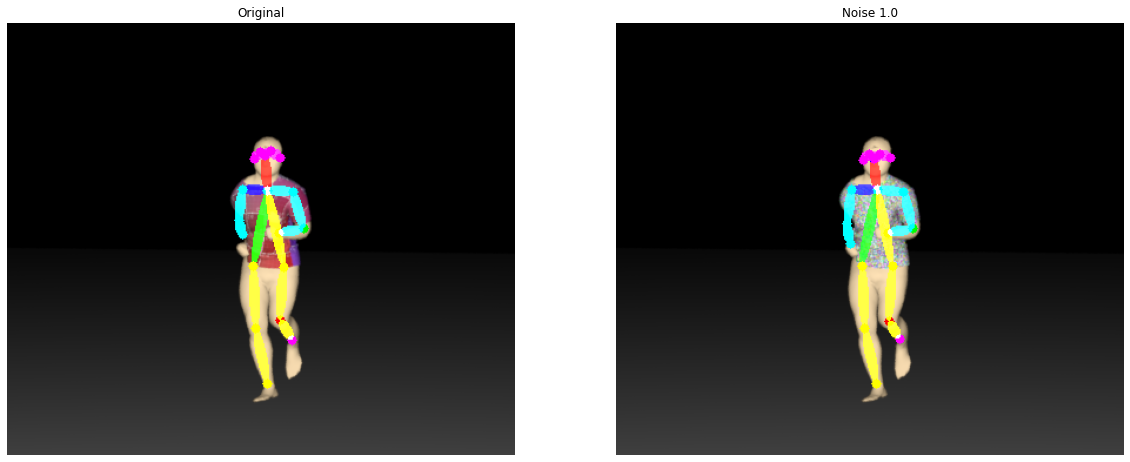

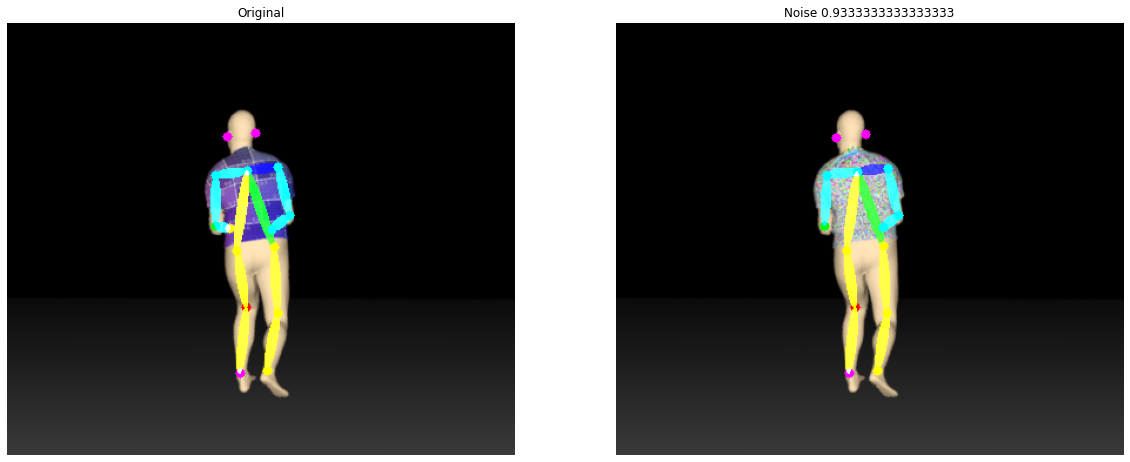

In [8]:
plot_cnt = 16
figures = []
for i in range(plot_cnt):
    fig = plt.figure(figsize=(20, 80))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(canvas_orig_list[i])
    ax.axis('off')
    ax.set_title('Original')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(canvas_noise_list[i])
    ax.axis('off')
    ax.set_title(f'Noise {metric_list[i]}')

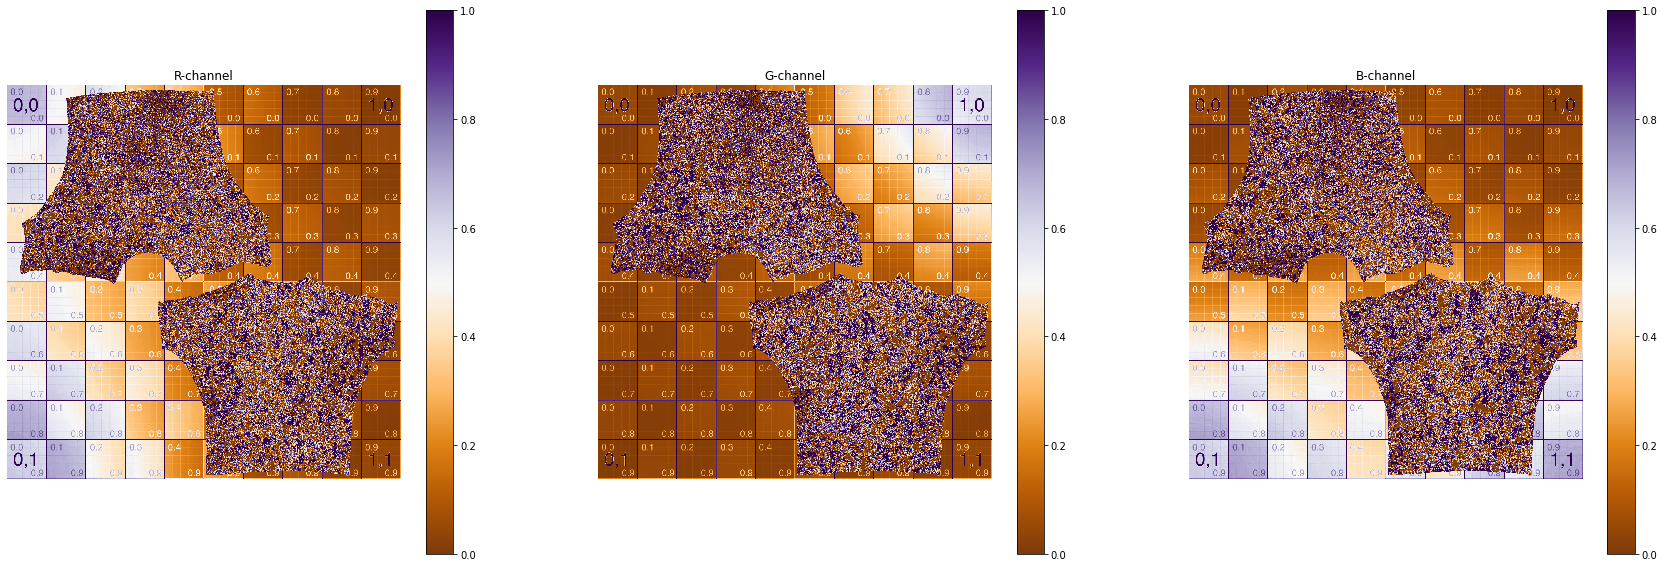

In [9]:
universal_noise_image = params_torch[diff_parameter].detach().cpu().numpy()
universal_noise_image  = universal_noise_image.reshape(noise_resolution[1], noise_resolution[0], -1)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
im = ax.imshow(universal_noise_image[:,:, 0], interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('R-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 2)
im = ax.imshow(universal_noise_image[:,:, 1], interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('G-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 3)
im = ax.imshow(universal_noise_image[:,:, 2],  interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('B-channel')
fig.colorbar(im, ax=ax)

In [ ]:
thread = Thread.thread()
thread.file_resolver().append(test_dir)
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)

print(test_scenes[0])
# load scene
scene = load_file(test_scenes[0])
params = traverse(scene)
rendering_torch = render_torch(scene, spp=16)
rendering_torch_np = rendering_torch.detach().cpu().numpy()
rendering_np = np.array(render(scene, spp=16)).reshape(ORIG_SHAPE[0], ORIG_SHAPE[1], ORIG_SHAPE[2])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(rendering_np)
ax.axis('off')
ax.set_title('Original')
print(f'rendering_np shape: {rendering_np.shape}')
print(f'min: {np.min(rendering_np)}')
print(f"max: {np.max(rendering_np)}")
print(f'mean: {np.mean(rendering_np)}')

print(f'rendering_torch_np shape: {rendering_torch_np.shape}')
print(f'min: {np.min(rendering_torch_np)}')
print(f"max: {np.max(rendering_torch_np)}")
print(f'mean: {np.mean(rendering_torch_np)}')

../data/tshirt/test/00046.xml


In [ ]:

canvas_orig, candidate_orig, subset_orig = get_candidate_from_tensor(rendering_torch, body_estimation)


# update the params with the new noise value
params[diff_parameter] = params_torch[diff_parameter].detach().cpu().numpy()
params.update()

rendering_torch = render_torch(scene, params=params, unbiased=True, spp=spp, **params_torch)
canvas_noise, candidate_noise, subset_noise = get_candidate_from_tensor(rendering_torch, body_estimation)

canvas_orig, canvas_noise, metric, rendering_torch = get_image_and_score(test_scenes[0], params_torch, body_estimation, diff_parameter)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig)
ax.axis('off')
ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)
ax.axis('off')
ax.set_title(f'Noise {metric}')

In [ ]:
rendering_torch_np = rendering_torch.detach().cpu().numpy()

In [ ]:
print(np.min(rendering_torch_np))
print(np.max(rendering_torch_np))
print(np.mean(rendering_torch_np))